In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Reading data from files

In [2]:
intraday_data = pd.read_pickle('./intraday_20_stocks_data.pkl')
daily_data = pd.read_pickle('./daily_100_stocks_data.pkl')
intraday_symbols = ['NERV', 'LUV', 'SAVE', 'CTRM', 'SENS', 'CTRC', 'SXTC', 'CLBS', 'ELGX', 'AKRX', 'ENTX', 'RNET', 'IDEX', 'GNC', 'JILL', 'PRTY', 'KIRK', 'M', 'SQBG', 'FRAN']
daily_symbols = ['MSFT', 'AAPL', 'AMZN', 'GOOG', 'FB', 'JNJ', 'GOOGL', 'WMT', 'PG', 'V', 'JPM', 'UNH', 'MA', 'INTC', 'AMD', 'NVDA', 'VZ', 'HD', 'T', 'NFLX', 'TSLA', 'BA', 'SNAP', 'COST', 'TWTR', 'MRK', 'PEP', 'VLO', 'HAL', 'STT', 'ROK', 'EFX', 'GWW', 'TSN', 'HFC', 'ITW', 'USB', 'SHW', 'TJX', 'MDT', 'WBA', 'ABT', 'ADP', 'HRL', 'VFC', 'LOW', 'MCD', 'AFL', 'DG', 'KSU', 'MO', 'SKT', 'ENB', 'WELL', 'SO', 'D', 'O', 'NNN', 'XOM', 'MDP', 'GIS', 'IBM', 'DUK', 'MDB', 'CRM', 'NOW', 'VMW', 'IT', 'UGAZ', 'DGAZ', 'A', 'AA', 'AAP', 'AAXN', 'ABB', 'ABBV', 'ABEV', 'ABMD', 'ACAD', 'ACER', 'ACGL', 'ACHV', 'ACIW', 'ACMR', 'ACN', 'ACOR', 'ACRX', 'ACTG', 'ACY', 'ADBE', 'ADI', 'ADM', 'ADPT', 'ADS', 'ADSK', 'ADT', 'AEG', 'AEHR', 'AEP', 'AER']

In [3]:
daily_train_data = daily_data[['Close', 'Volume', 'volume_change', 'volume_score', 'bearish', 'bullish']]
intraday_train_data = intraday_data[['close', 'volume', 'trending_score', 'sentiment_change', 'volume_change']]

## Defining MLP model

In [4]:
class MLP(nn.Module):
    def __init__(self, num_feat):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_feat, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.layers(x)
        return x

## Normalization of data

In [5]:
def normalize_Data(data):
    
    data_mean = np.mean(data, axis = 0)
    data_std = np.std(data, axis = 0)
    return (data - data_mean)/data_std

## Train function

In [6]:
def train(data, epoch, batchsize,lr, num_feat):
    gt = data[:,0]
    data = data[:,1:]
    data = normalize_Data(data)
    l = gt.shape[0]
    test_size = l//4
    test_gt = gt[:test_size]
    test_data = data[:test_size]
    train_gt = gt[test_size:]
    train_data = data[test_size:]
    mlpModel = MLP(num_feat)
    optimizer = torch.optim.SGD(mlpModel.parameters(), lr=lr)
    criteria = nn.MSELoss()
    
    for i in range(epoch):
        loss_values = []
        for j in range(0,train_gt.shape[0],batchsize):
            if (j+batchsize < train_data.shape[0]):
                d = train_data[j:j+batchsize]
                l = train_gt[j:j+batchsize]
            else:
                d = train_data[j:]
                l = train_gt[j:]
            d = torch.from_numpy(d).float()
            l = torch.from_numpy(l).float()
            l = l.view(l.size(0),-1)
            optimizer.zero_grad()
            out = mlpModel(d)
            loss = criteria(out, l)
            loss.backward()
            optimizer.step()
            loss_values.append(loss.item())
        loss_values = np.array(loss_values)
        print("Loss after epoch: " + str(i) + " = " + str(np.mean(loss_values)))
    test_data = torch.from_numpy(test_data).float()
    test_gt = torch.from_numpy(test_gt).float()
    test_pred = mlpModel(test_data)
    return test_pred, test_gt

## Train function wrapper

In [7]:
def main_train_intraday(symbol, epoch, batchsize,lr):
    data = intraday_data.loc[intraday_data['Symbol'] == symbol][['close','volume', 'trending_score', 'sentiment_change', 'volume_change']].to_numpy()
    test_pred, test_gt = train(data, epoch, batchsize,lr, 4)
    plt.figure()
    plt.plot(np.arange(test_pred.size(0)), test_pred.detach().numpy(), c = 'r', label = "prediction")
    plt.plot(np.arange(test_gt.size(0)), test_gt.detach().numpy(), c = 'b', label = "ground truth")
    plt.title(symbol + " intraday data")
    plt.legend()
    plt.show()

def main_train_daily(symbol, epoch, batchsize,lr):
    data = daily_data.loc[daily_data['Symbol'] == symbol][['Close','Volume', 'volume_change', 'volume_score', 'bearish', 'bullish']].dropna().to_numpy()
    test_pred, test_gt = train(data, epoch, batchsize,lr, 5)
    plt.figure()
    plt.plot(np.arange(test_pred.size(0)), test_pred.detach().numpy(), c = 'r', label = "prediction")
    plt.plot(np.arange(test_gt.size(0)), test_gt.detach().numpy(), c = 'b', label = "ground truth")
    plt.title(symbol + " daily data")
    plt.legend()
    plt.show()

Loss after epoch: 0 = 0.29715510032954445
Loss after epoch: 1 = 0.0052342823930181335
Loss after epoch: 2 = 0.0032974957287673795
Loss after epoch: 3 = 0.002799620029657067
Loss after epoch: 4 = 0.0024318965094750514
Loss after epoch: 5 = 0.0021747868675894002
Loss after epoch: 6 = 0.0020233799887130768
Loss after epoch: 7 = 0.001933075649785882
Loss after epoch: 8 = 0.0018715796062034602
Loss after epoch: 9 = 0.0018239419621438686
Loss after epoch: 10 = 0.0017844903010766984
Loss after epoch: 11 = 0.0017508710890870363
Loss after epoch: 12 = 0.0017217496571755178
Loss after epoch: 13 = 0.001697133007202702
Loss after epoch: 14 = 0.0016765619748082786
Loss after epoch: 15 = 0.0016596839838606459
Loss after epoch: 16 = 0.0016446284514423887
Loss after epoch: 17 = 0.001631518457772564
Loss after epoch: 18 = 0.0016200382472374365
Loss after epoch: 19 = 0.0016098384309862776
Loss after epoch: 20 = 0.0016012597926739127
Loss after epoch: 21 = 0.0015927982996757947
Loss after epoch: 22 = 0.0

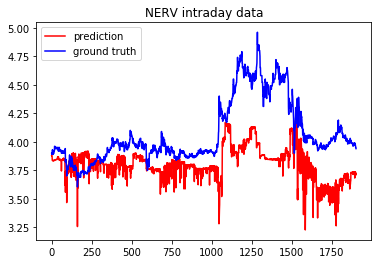

In [8]:
main_train_intraday('NERV', 50, 8, 0.01)

Loss after epoch: 0 = 166.0827882400957
Loss after epoch: 1 = 1.554479166369317
Loss after epoch: 2 = 0.7577326618629151
Loss after epoch: 3 = 0.5197952788482587
Loss after epoch: 4 = 0.4215959332302931
Loss after epoch: 5 = 0.3630412118643148
Loss after epoch: 6 = 0.3337836358997276
Loss after epoch: 7 = 0.3117870623848532
Loss after epoch: 8 = 0.29582263311650875
Loss after epoch: 9 = 0.2852878602529172
Loss after epoch: 10 = 0.2772358161481703
Loss after epoch: 11 = 0.27118406743526424
Loss after epoch: 12 = 0.2662884607178035
Loss after epoch: 13 = 0.26170670522375955
Loss after epoch: 14 = 0.2577593533429086
Loss after epoch: 15 = 0.2540696291878939
Loss after epoch: 16 = 0.2509309532541651
Loss after epoch: 17 = 0.247910396307665
Loss after epoch: 18 = 0.24520532739234296
Loss after epoch: 19 = 0.242870586461775
Loss after epoch: 20 = 0.24035847091064402
Loss after epoch: 21 = 0.23830126604822469
Loss after epoch: 22 = 0.2362242194839592
Loss after epoch: 23 = 0.23430435651998005

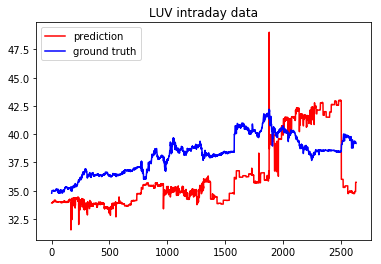

In [9]:
main_train_intraday('LUV', 50, 8, 0.0001)

Loss after epoch: 0 = 0.004032690720993044
Loss after epoch: 1 = 0.0003841112140552285
Loss after epoch: 2 = 0.000311640501888452
Loss after epoch: 3 = 0.0002811959064018255
Loss after epoch: 4 = 0.00026599062734039157
Loss after epoch: 5 = 0.0002569760439260512
Loss after epoch: 6 = 0.0002503772536474458
Loss after epoch: 7 = 0.0002443769829062022
Loss after epoch: 8 = 0.000239440189487625
Loss after epoch: 9 = 0.0002353412574316095
Loss after epoch: 10 = 0.000231323216881007
Loss after epoch: 11 = 0.00022705913512760187
Loss after epoch: 12 = 0.00022304362878081973
Loss after epoch: 13 = 0.00021929654996670435
Loss after epoch: 14 = 0.00021566493581875613
Loss after epoch: 15 = 0.00021227858814257491
Loss after epoch: 16 = 0.00021002442642364795
Loss after epoch: 17 = 0.000207459443098998
Loss after epoch: 18 = 0.00020501156993709403
Loss after epoch: 19 = 0.0002026322047238128
Loss after epoch: 20 = 0.00020063524208414795
Loss after epoch: 21 = 0.0001985377513886611
Loss after epoch

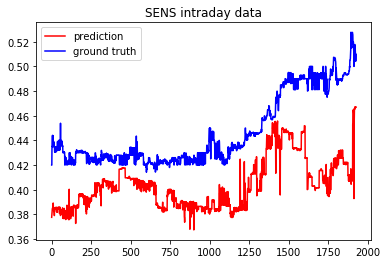

In [10]:
main_train_intraday('SENS', 70, 8, 0.01)

Loss after epoch: 0 = 0.0024163905811812065
Loss after epoch: 1 = 0.002114309662283631
Loss after epoch: 2 = 0.0018978499444658934
Loss after epoch: 3 = 0.0017399142579441623
Loss after epoch: 4 = 0.001622057640010358
Loss after epoch: 5 = 0.001531903242201744
Loss after epoch: 6 = 0.0014609530677262227
Loss after epoch: 7 = 0.0014034063509565644
Loss after epoch: 8 = 0.0013552927497325331
Loss after epoch: 9 = 0.0013139408401912078
Loss after epoch: 10 = 0.001277536378932252
Loss after epoch: 11 = 0.0012447849633255308
Loss after epoch: 12 = 0.0012147891765510264
Loss after epoch: 13 = 0.0011869810018522132
Loss after epoch: 14 = 0.00116092960275377
Loss after epoch: 15 = 0.0011363219446918395
Loss after epoch: 16 = 0.001112958172494213
Loss after epoch: 17 = 0.0010906865352548526
Loss after epoch: 18 = 0.0010693233453951377
Loss after epoch: 19 = 0.0010488025744312575
Loss after epoch: 20 = 0.0010291084046392435
Loss after epoch: 21 = 0.001010204600087101
Loss after epoch: 22 = 0.000

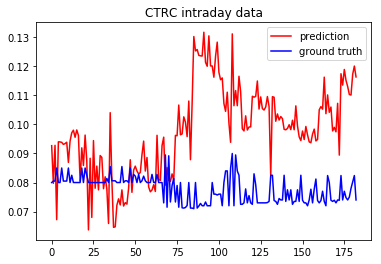

In [11]:
main_train_intraday('CTRC', 50, 16, 0.001)

Loss after epoch: 0 = 33378.475477430555
Loss after epoch: 1 = 33352.46267361111
Loss after epoch: 2 = 33325.98263888889
Loss after epoch: 3 = 33298.82790798611
Loss after epoch: 4 = 33270.510850694445
Loss after epoch: 5 = 33240.008463541664
Loss after epoch: 6 = 33206.69118923611
Loss after epoch: 7 = 33169.16644965278
Loss after epoch: 8 = 33125.60373263889
Loss after epoch: 9 = 33073.88693576389
Loss after epoch: 10 = 33011.934895833336
Loss after epoch: 11 = 32935.934244791664
Loss after epoch: 12 = 32840.409505208336
Loss after epoch: 13 = 32717.251953125
Loss after epoch: 14 = 32554.201605902777
Loss after epoch: 15 = 32331.600260416668
Loss after epoch: 16 = 32016.520182291668
Loss after epoch: 17 = 31551.642144097223
Loss after epoch: 18 = 30832.02951388889
Loss after epoch: 19 = 29653.061631944445
Loss after epoch: 20 = 27608.868272569445
Loss after epoch: 21 = 23926.512369791668
Loss after epoch: 22 = 17627.48122829861
Loss after epoch: 23 = 9803.886067708334
Loss after epoc

Loss after epoch: 209 = 66.44629436069064
Loss after epoch: 210 = 66.18863783942328
Loss after epoch: 211 = 65.98337258232965
Loss after epoch: 212 = 65.70458020104303
Loss after epoch: 213 = 65.49265437655978
Loss after epoch: 214 = 65.24770630730524
Loss after epoch: 215 = 65.00650268130832
Loss after epoch: 216 = 64.79832013448079
Loss after epoch: 217 = 64.54021665785048
Loss after epoch: 218 = 64.34217993418376
Loss after epoch: 219 = 64.08781337738037
Loss after epoch: 220 = 63.88812722100152
Loss after epoch: 221 = 63.67209392123752
Loss after epoch: 222 = 63.439735624525284
Loss after epoch: 223 = 63.24044026268853
Loss after epoch: 224 = 62.99622578091092
Loss after epoch: 225 = 62.8049382103814
Loss after epoch: 226 = 62.60675472683377
Loss after epoch: 227 = 62.3759642706977
Loss after epoch: 228 = 62.17595545450846
Loss after epoch: 229 = 61.9704205195109
Loss after epoch: 230 = 61.762037701076935
Loss after epoch: 231 = 61.588971032036675
Loss after epoch: 232 = 61.3618450

Loss after epoch: 426 = 39.81037373012967
Loss after epoch: 427 = 39.741953955756294
Loss after epoch: 428 = 39.67728323406644
Loss after epoch: 429 = 39.589608351389565
Loss after epoch: 430 = 39.5347711775038
Loss after epoch: 431 = 39.48230245378282
Loss after epoch: 432 = 39.400514390733505
Loss after epoch: 433 = 39.354338539971245
Loss after epoch: 434 = 39.26537556118436
Loss after epoch: 435 = 39.19975996017456
Loss after epoch: 436 = 39.15677446789212
Loss after epoch: 437 = 39.082143783569336
Loss after epoch: 438 = 39.01298480563693
Loss after epoch: 439 = 38.943937089708115
Loss after epoch: 440 = 38.89496734407213
Loss after epoch: 441 = 38.83044401804606
Loss after epoch: 442 = 38.757040076785614
Loss after epoch: 443 = 38.708881537119545
Loss after epoch: 444 = 38.627286752065025
Loss after epoch: 445 = 38.580499437120224
Loss after epoch: 446 = 38.52299133936564
Loss after epoch: 447 = 38.454866621229385
Loss after epoch: 448 = 38.399092250400116
Loss after epoch: 449 =

Loss after epoch: 633 = 30.505819612079197
Loss after epoch: 634 = 30.487305641174316
Loss after epoch: 635 = 30.451291932000053
Loss after epoch: 636 = 30.409763389163547
Loss after epoch: 637 = 30.38174255688985
Loss after epoch: 638 = 30.353106445736355
Loss after epoch: 639 = 30.314457363552517
Loss after epoch: 640 = 30.289915243784588
Loss after epoch: 641 = 30.24426296022203
Loss after epoch: 642 = 30.217111084196304
Loss after epoch: 643 = 30.19002898534139
Loss after epoch: 644 = 30.151155948638916
Loss after epoch: 645 = 30.121314181221855
Loss after epoch: 646 = 30.07376350296868
Loss after epoch: 647 = 30.055701706144546
Loss after epoch: 648 = 30.026252799563938
Loss after epoch: 649 = 29.977304961946274
Loss after epoch: 650 = 29.954185009002686
Loss after epoch: 651 = 29.936859342787002
Loss after epoch: 652 = 29.880861229366726
Loss after epoch: 653 = 29.8562650680542
Loss after epoch: 654 = 29.814043468899197
Loss after epoch: 655 = 29.78987185160319
Loss after epoch: 

Loss after epoch: 828 = 25.002092639605205
Loss after epoch: 829 = 24.96554089917077
Loss after epoch: 830 = 24.949490719371372
Loss after epoch: 831 = 24.93186758624183
Loss after epoch: 832 = 24.912247975667317
Loss after epoch: 833 = 24.876670082410175
Loss after epoch: 834 = 24.851893133587307
Loss after epoch: 835 = 24.828368888960945
Loss after epoch: 836 = 24.811445620324875
Loss after epoch: 837 = 24.78421033753289
Loss after epoch: 838 = 24.76374289724562
Loss after epoch: 839 = 24.7482295566135
Loss after epoch: 840 = 24.70866592725118
Loss after epoch: 841 = 24.693503790431553
Loss after epoch: 842 = 24.667677905824448
Loss after epoch: 843 = 24.641828894615173
Loss after epoch: 844 = 24.628039320309956
Loss after epoch: 845 = 24.60714015695784
Loss after epoch: 846 = 24.578914841016132
Loss after epoch: 847 = 24.54820003774431
Loss after epoch: 848 = 24.532456596692402
Loss after epoch: 849 = 24.507496343718636
Loss after epoch: 850 = 24.48712917168935
Loss after epoch: 851

Loss after epoch: 1024 = 20.746521373589832
Loss after epoch: 1025 = 20.708605421913994
Loss after epoch: 1026 = 20.705746432145435
Loss after epoch: 1027 = 20.672307160165573
Loss after epoch: 1028 = 20.65480426285002
Loss after epoch: 1029 = 20.644003444247776
Loss after epoch: 1030 = 20.609355946381886
Loss after epoch: 1031 = 20.589061028427547
Loss after epoch: 1032 = 20.575659745269352
Loss after epoch: 1033 = 20.56640562083986
Loss after epoch: 1034 = 20.533563938405777
Loss after epoch: 1035 = 20.507884667979347
Loss after epoch: 1036 = 20.494363374180264
Loss after epoch: 1037 = 20.484423557917278
Loss after epoch: 1038 = 20.453746914863586
Loss after epoch: 1039 = 20.430101361539627
Loss after epoch: 1040 = 20.41730014483134
Loss after epoch: 1041 = 20.404854211542343
Loss after epoch: 1042 = 20.37475918398963
Loss after epoch: 1043 = 20.3516426814927
Loss after epoch: 1044 = 20.34572286076016
Loss after epoch: 1045 = 20.307184471024406
Loss after epoch: 1046 = 20.31474086311

Loss after epoch: 1216 = 17.322355025344425
Loss after epoch: 1217 = 17.29813372426563
Loss after epoch: 1218 = 17.282283167044323
Loss after epoch: 1219 = 17.273045539855957
Loss after epoch: 1220 = 17.25281328625149
Loss after epoch: 1221 = 17.234408213032616
Loss after epoch: 1222 = 17.224648230605656
Loss after epoch: 1223 = 17.20237891541587
Loss after epoch: 1224 = 17.20311932431327
Loss after epoch: 1225 = 17.177114678753746
Loss after epoch: 1226 = 17.149624201986526
Loss after epoch: 1227 = 17.141004184881847
Loss after epoch: 1228 = 17.133635540803272
Loss after epoch: 1229 = 17.101944155163235
Loss after epoch: 1230 = 17.10381108522415
Loss after epoch: 1231 = 17.07596942451265
Loss after epoch: 1232 = 17.068738089667427
Loss after epoch: 1233 = 17.038313541147446
Loss after epoch: 1234 = 17.02731105354097
Loss after epoch: 1235 = 17.023186445236206
Loss after epoch: 1236 = 16.991628030935924
Loss after epoch: 1237 = 16.993839005629223
Loss after epoch: 1238 = 16.96479998032

Loss after epoch: 1404 = 14.744411461883121
Loss after epoch: 1405 = 14.719778130451838
Loss after epoch: 1406 = 14.72058336933454
Loss after epoch: 1407 = 14.710000839498308
Loss after epoch: 1408 = 14.693231602509817
Loss after epoch: 1409 = 14.687061144245995
Loss after epoch: 1410 = 14.66679016749064
Loss after epoch: 1411 = 14.667682551675373
Loss after epoch: 1412 = 14.652342249949774
Loss after epoch: 1413 = 14.639766673247019
Loss after epoch: 1414 = 14.628613071309196
Loss after epoch: 1415 = 14.613318810860315
Loss after epoch: 1416 = 14.612699379523596
Loss after epoch: 1417 = 14.594511644707787
Loss after epoch: 1418 = 14.58118455277549
Loss after epoch: 1419 = 14.575256685415903
Loss after epoch: 1420 = 14.570340232716667
Loss after epoch: 1421 = 14.544820202721489
Loss after epoch: 1422 = 14.549402458800209
Loss after epoch: 1423 = 14.520077665646872
Loss after epoch: 1424 = 14.535992542902628
Loss after epoch: 1425 = 14.514048821396297
Loss after epoch: 1426 = 14.4892300

Loss after epoch: 1616 = 12.683725645144781
Loss after epoch: 1617 = 12.6687527332041
Loss after epoch: 1618 = 12.647997226979998
Loss after epoch: 1619 = 12.65840689672364
Loss after epoch: 1620 = 12.647514522075653
Loss after epoch: 1621 = 12.625626650121477
Loss after epoch: 1622 = 12.630267298883862
Loss after epoch: 1623 = 12.614444262451595
Loss after epoch: 1624 = 12.60082937280337
Loss after epoch: 1625 = 12.607854770289528
Loss after epoch: 1626 = 12.592198739449183
Loss after epoch: 1627 = 12.574540005789864
Loss after epoch: 1628 = 12.575742897060183
Loss after epoch: 1629 = 12.563980870776707
Loss after epoch: 1630 = 12.5521516667472
Loss after epoch: 1631 = 12.554333686828613
Loss after epoch: 1632 = 12.539642145236334
Loss after epoch: 1633 = 12.522393571005928
Loss after epoch: 1634 = 12.520909382237328
Loss after epoch: 1635 = 12.515046659443113
Loss after epoch: 1636 = 12.499458948771158
Loss after epoch: 1637 = 12.502964880731371
Loss after epoch: 1638 = 12.4914416505

Loss after epoch: 1837 = 10.935209999481836
Loss after epoch: 1838 = 10.924523413181305
Loss after epoch: 1839 = 10.90808610121409
Loss after epoch: 1840 = 10.920092698600557
Loss after epoch: 1841 = 10.905468026796976
Loss after epoch: 1842 = 10.89494929379887
Loss after epoch: 1843 = 10.88081098596255
Loss after epoch: 1844 = 10.883183929655287
Loss after epoch: 1845 = 10.879032853576872
Loss after epoch: 1846 = 10.861332250965965
Loss after epoch: 1847 = 10.865598208374447
Loss after epoch: 1848 = 10.854710244470173
Loss after epoch: 1849 = 10.844877004623413
Loss after epoch: 1850 = 10.82977431681421
Loss after epoch: 1851 = 10.838688416613472
Loss after epoch: 1852 = 10.825144191582998
Loss after epoch: 1853 = 10.808798472086588
Loss after epoch: 1854 = 10.813476082351473
Loss after epoch: 1855 = 10.80505101548301
Loss after epoch: 1856 = 10.79787340760231
Loss after epoch: 1857 = 10.782766845491198
Loss after epoch: 1858 = 10.784916039970186
Loss after epoch: 1859 = 10.7736442287

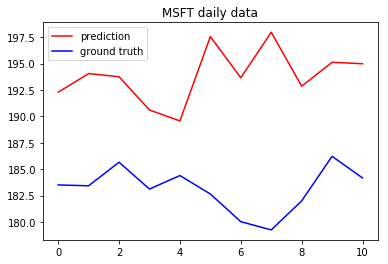

In [12]:
main_train_daily('MSFT', 2000, 4, 0.00001)

Loss after epoch: 0 = 5924876.277777778
Loss after epoch: 1 = 5924528.388888889
Loss after epoch: 2 = 5924171.944444444
Loss after epoch: 3 = 5923793.0
Loss after epoch: 4 = 5923384.333333333
Loss after epoch: 5 = 5922934.722222222
Loss after epoch: 6 = 5922427.166666667
Loss after epoch: 7 = 5921841.388888889
Loss after epoch: 8 = 5921142.055555556
Loss after epoch: 9 = 5920292.444444444
Loss after epoch: 10 = 5919232.111111111
Loss after epoch: 11 = 5917848.5
Loss after epoch: 12 = 5915969.611111111
Loss after epoch: 13 = 5913297.833333333
Loss after epoch: 14 = 5909262.888888889
Loss after epoch: 15 = 5902720.833333333
Loss after epoch: 16 = 5891071.388888889
Loss after epoch: 17 = 5867486.388888889
Loss after epoch: 18 = 5809295.388888889
Loss after epoch: 19 = 5603482.722222222
Loss after epoch: 20 = 4051442.388888889
Loss after epoch: 21 = 477037.8072916667
Loss after epoch: 22 = 115587.33420138889
Loss after epoch: 23 = 85700.44281684028
Loss after epoch: 24 = 84979.55563693577


Loss after epoch: 208 = 13412.439480251736
Loss after epoch: 209 = 13699.692979600695
Loss after epoch: 210 = 14948.12151421441
Loss after epoch: 211 = 14095.902140299479
Loss after epoch: 212 = 12490.83433702257
Loss after epoch: 213 = 15882.09290907118
Loss after epoch: 214 = 15397.038899739584
Loss after epoch: 215 = 12137.710557725695
Loss after epoch: 216 = 14296.7431640625
Loss after epoch: 217 = 14905.794284396701
Loss after epoch: 218 = 13641.075636121961
Loss after epoch: 219 = 13603.051079644098
Loss after epoch: 220 = 13972.984144422742
Loss after epoch: 221 = 16308.085808648004
Loss after epoch: 222 = 14778.769219292535
Loss after epoch: 223 = 12989.4990234375
Loss after epoch: 224 = 18530.95273844401
Loss after epoch: 225 = 17716.060045030383
Loss after epoch: 226 = 12576.969021267361
Loss after epoch: 227 = 16804.19276936849
Loss after epoch: 228 = 17095.301897260877
Loss after epoch: 229 = 14071.762159559461
Loss after epoch: 230 = 14324.631022135416
Loss after epoch: 23

Loss after epoch: 436 = 10890.934853447809
Loss after epoch: 437 = 10868.784149169922
Loss after epoch: 438 = 10745.575995551215
Loss after epoch: 439 = 12918.530815972223
Loss after epoch: 440 = 11478.761027018229
Loss after epoch: 441 = 10098.629692925348
Loss after epoch: 442 = 14792.501085069445
Loss after epoch: 443 = 12920.97740342882
Loss after epoch: 444 = 9656.0263671875
Loss after epoch: 445 = 14825.921983506945
Loss after epoch: 446 = 13435.930867513021
Loss after epoch: 447 = 9298.76722547743
Loss after epoch: 448 = 12645.269232855902
Loss after epoch: 449 = 12077.177924262152
Loss after epoch: 450 = 9536.6765560574
Loss after epoch: 451 = 10554.378377278646
Loss after epoch: 452 = 10554.657161288791
Loss after epoch: 453 = 10728.252309163412
Loss after epoch: 454 = 9971.532538519965
Loss after epoch: 455 = 9287.356770833334
Loss after epoch: 456 = 11593.558268229166
Loss after epoch: 457 = 10354.487616644965
Loss after epoch: 458 = 8622.92487250434
Loss after epoch: 459 = 

Loss after epoch: 667 = 7031.689914279514
Loss after epoch: 668 = 7100.891060723199
Loss after epoch: 669 = 6277.277423434787
Loss after epoch: 670 = 6758.090603298611
Loss after epoch: 671 = 6672.7045491536455
Loss after epoch: 672 = 6798.908189561632
Loss after epoch: 673 = 6818.6780192057295
Loss after epoch: 674 = 6254.254530164931
Loss after epoch: 675 = 7145.276095920139
Loss after epoch: 676 = 7076.160208808051
Loss after epoch: 677 = 6005.595560709636
Loss after epoch: 678 = 7147.8779703776045
Loss after epoch: 679 = 7159.94974093967
Loss after epoch: 680 = 5974.353861490886
Loss after epoch: 681 = 6909.230109320746
Loss after epoch: 682 = 7050.119565327962
Loss after epoch: 683 = 6370.907651265462
Loss after epoch: 684 = 6835.476915147569
Loss after epoch: 685 = 6850.216179741754
Loss after epoch: 686 = 7100.503716362848
Loss after epoch: 687 = 7100.798014322917
Loss after epoch: 688 = 6401.796617296007
Loss after epoch: 689 = 7624.2420654296875
Loss after epoch: 690 = 7519.03

Loss after epoch: 894 = 5827.468270195855
Loss after epoch: 895 = 6300.801005045573
Loss after epoch: 896 = 6403.69524468316
Loss after epoch: 897 = 6835.146565755208
Loss after epoch: 898 = 6933.759284125434
Loss after epoch: 899 = 5744.7245686848955
Loss after epoch: 900 = 7350.312594943576
Loss after epoch: 901 = 7651.7890218098955
Loss after epoch: 902 = 5411.063096788194
Loss after epoch: 903 = 6941.313340928819
Loss after epoch: 904 = 7612.162777370877
Loss after epoch: 905 = 5930.727739122179
Loss after epoch: 906 = 6561.843655056424
Loss after epoch: 907 = 6913.065802680121
Loss after epoch: 908 = 7269.348524305556
Loss after epoch: 909 = 7294.43707953559
Loss after epoch: 910 = 6110.825995551215
Loss after epoch: 911 = 8095.567084418402
Loss after epoch: 912 = 8186.55857679579
Loss after epoch: 913 = 5644.6858317057295
Loss after epoch: 914 = 7509.277601453993
Loss after epoch: 915 = 8212.968519422742
Loss after epoch: 916 = 5993.275939941406
Loss after epoch: 917 = 6764.81690

Loss after epoch: 1097 = 4399.542219373915
Loss after epoch: 1098 = 4779.786682128906
Loss after epoch: 1099 = 5027.326924218072
Loss after epoch: 1100 = 4195.985222710504
Loss after epoch: 1101 = 4707.040011935764
Loss after epoch: 1102 = 4960.608469645183
Loss after epoch: 1103 = 4208.223654005263
Loss after epoch: 1104 = 4645.809421115451
Loss after epoch: 1105 = 4610.56940375434
Loss after epoch: 1106 = 4430.14594523112
Loss after epoch: 1107 = 4686.983300103082
Loss after epoch: 1108 = 4287.9530198838975
Loss after epoch: 1109 = 4615.729994032118
Loss after epoch: 1110 = 4872.581661648221
Loss after epoch: 1111 = 4098.041286892361
Loss after epoch: 1112 = 4580.157904730902
Loss after epoch: 1113 = 4793.489974127875
Loss after epoch: 1114 = 4190.53720940484
Loss after epoch: 1115 = 4555.936008029514
Loss after epoch: 1116 = 4541.033442179362
Loss after epoch: 1117 = 4455.900312635634
Loss after epoch: 1118 = 4740.873082478841
Loss after epoch: 1119 = 4242.355187310113
Loss after ep

Loss after epoch: 1292 = 5451.512878417969
Loss after epoch: 1293 = 6243.439053005643
Loss after epoch: 1294 = 4579.248629252116
Loss after epoch: 1295 = 5239.067064073351
Loss after epoch: 1296 = 5443.671732584636
Loss after epoch: 1297 = 5248.069444444444
Loss after epoch: 1298 = 5651.1163330078125
Loss after epoch: 1299 = 4689.784423828125
Loss after epoch: 1300 = 5603.160786946614
Loss after epoch: 1301 = 6217.773139105902
Loss after epoch: 1302 = 4315.617465549045
Loss after epoch: 1303 = 5165.882175021701
Loss after epoch: 1304 = 5839.978529188368
Loss after epoch: 1305 = 4576.771091461182
Loss after epoch: 1306 = 5088.9979248046875
Loss after epoch: 1307 = 4966.285624186198
Loss after epoch: 1308 = 5073.738864474826
Loss after epoch: 1309 = 5477.958079020183
Loss after epoch: 1310 = 4329.695095486111
Loss after epoch: 1311 = 5213.046434190538
Loss after epoch: 1312 = 5760.150444878473
Loss after epoch: 1313 = 4120.775519476996
Loss after epoch: 1314 = 4836.661444769965
Loss afte

Loss after epoch: 1493 = 4011.0394151475693
Loss after epoch: 1494 = 4868.184143066406
Loss after epoch: 1495 = 5575.360249837239
Loss after epoch: 1496 = 4083.109927707248
Loss after epoch: 1497 = 4803.652160644531
Loss after epoch: 1498 = 5058.367062038846
Loss after epoch: 1499 = 4724.109608968099
Loss after epoch: 1500 = 5280.809271918402
Loss after epoch: 1501 = 4468.725484212239
Loss after epoch: 1502 = 5284.7269117567275
Loss after epoch: 1503 = 5956.199513753255
Loss after epoch: 1504 = 4104.451151529948
Loss after epoch: 1505 = 5026.13030327691
Loss after epoch: 1506 = 5778.4994066026475
Loss after epoch: 1507 = 4476.848633236355
Loss after epoch: 1508 = 5070.133972167969
Loss after epoch: 1509 = 5044.023796929254
Loss after epoch: 1510 = 5140.599962022569
Loss after epoch: 1511 = 5786.552897135417
Loss after epoch: 1512 = 4338.049336751302
Loss after epoch: 1513 = 5383.8691813151045
Loss after epoch: 1514 = 6155.115234375
Loss after epoch: 1515 = 4181.795104980469
Loss after 

Loss after epoch: 1709 = 4037.583102756076
Loss after epoch: 1710 = 4325.141966078017
Loss after epoch: 1711 = 3651.5935134887695
Loss after epoch: 1712 = 4290.431430392795
Loss after epoch: 1713 = 3824.0387369791665
Loss after epoch: 1714 = 3997.3114183213975
Loss after epoch: 1715 = 4675.929468154907
Loss after epoch: 1716 = 3510.5775790744356
Loss after epoch: 1717 = 4121.277028401692
Loss after epoch: 1718 = 4691.583624945746
Loss after epoch: 1719 = 3624.709230211046
Loss after epoch: 1720 = 4327.399190266927
Loss after epoch: 1721 = 4258.293060302734
Loss after epoch: 1722 = 4087.675784640842
Loss after epoch: 1723 = 4835.518154568143
Loss after epoch: 1724 = 3796.0772501627603
Loss after epoch: 1725 = 4405.158074273004
Loss after epoch: 1726 = 5227.73932562934
Loss after epoch: 1727 = 3699.449259440104
Loss after epoch: 1728 = 4488.627102322049
Loss after epoch: 1729 = 4838.731001112196
Loss after epoch: 1730 = 4134.947758992513
Loss after epoch: 1731 = 4916.028964572482
Loss af

Loss after epoch: 1922 = 2963.703626844618
Loss after epoch: 1923 = 3441.148351033529
Loss after epoch: 1924 = 3448.1656943427192
Loss after epoch: 1925 = 3039.09152730306
Loss after epoch: 1926 = 3490.4789360894097
Loss after epoch: 1927 = 3036.9429965549043
Loss after epoch: 1928 = 3129.0857789781357
Loss after epoch: 1929 = 3480.703982035319
Loss after epoch: 1930 = 2796.9259321424697
Loss after epoch: 1931 = 3148.3221910264756
Loss after epoch: 1932 = 3272.460181342231
Loss after epoch: 1933 = 2782.5927691989473
Loss after epoch: 1934 = 3164.655193752713
Loss after epoch: 1935 = 3049.0207875569663
Loss after epoch: 1936 = 2954.6537517971465
Loss after epoch: 1937 = 3264.4056549072266
Loss after epoch: 1938 = 2802.1519368489585
Loss after epoch: 1939 = 2961.7035581800674
Loss after epoch: 1940 = 3249.1531965467666
Loss after epoch: 1941 = 2737.7356482611763
Loss after epoch: 1942 = 3043.7862786187065
Loss after epoch: 1943 = 3108.376975589328
Loss after epoch: 1944 = 2786.5270186530

Loss after epoch: 2132 = 3116.9634450276694
Loss after epoch: 2133 = 2782.044599745009
Loss after epoch: 2134 = 3399.9703776041665
Loss after epoch: 2135 = 2900.877532111274
Loss after epoch: 2136 = 3070.0300233629014
Loss after epoch: 2137 = 3636.9403177897134
Loss after epoch: 2138 = 2859.987041897244
Loss after epoch: 2139 = 3431.165540907118
Loss after epoch: 2140 = 3545.1331600613066
Loss after epoch: 2141 = 3080.186586168077
Loss after epoch: 2142 = 3763.8118693033853
Loss after epoch: 2143 = 3250.9351738823784
Loss after epoch: 2144 = 3550.5740424262153
Loss after epoch: 2145 = 4360.200490315755
Loss after epoch: 2146 = 3279.800610860189
Loss after epoch: 2147 = 3882.7362620035806
Loss after epoch: 2148 = 4349.509029812283
Loss after epoch: 2149 = 3625.229655371772
Loss after epoch: 2150 = 4519.086296929254
Loss after epoch: 2151 = 4038.454579671224
Loss after epoch: 2152 = 4362.815077039931
Loss after epoch: 2153 = 5497.697334289551
Loss after epoch: 2154 = 3924.0560514662
Loss

Loss after epoch: 2329 = 4085.56544664171
Loss after epoch: 2330 = 4610.260787116156
Loss after epoch: 2331 = 3218.3694763183594
Loss after epoch: 2332 = 3658.471939086914
Loss after epoch: 2333 = 3924.265899658203
Loss after epoch: 2334 = 3092.7214993370903
Loss after epoch: 2335 = 3544.169672648112
Loss after epoch: 2336 = 3218.685948689779
Loss after epoch: 2337 = 3114.210245768229
Loss after epoch: 2338 = 3498.3560985989043
Loss after epoch: 2339 = 2689.0184817843965
Loss after epoch: 2340 = 2982.732508341471
Loss after epoch: 2341 = 3170.7887674967446
Loss after epoch: 2342 = 2428.0806232028535
Loss after epoch: 2343 = 2853.957699245877
Loss after epoch: 2344 = 2678.045079549154
Loss after epoch: 2345 = 2469.9617716471353
Loss after epoch: 2346 = 2807.5651863945855
Loss after epoch: 2347 = 2298.0692812601724
Loss after epoch: 2348 = 2556.1792805989585
Loss after epoch: 2349 = 2689.6572511461045
Loss after epoch: 2350 = 2161.7719616360137
Loss after epoch: 2351 = 2460.524492051866


Loss after epoch: 2555 = 1776.3644869592454
Loss after epoch: 2556 = 1744.1396585040623
Loss after epoch: 2557 = 1803.8935819202
Loss after epoch: 2558 = 1727.0994760725234
Loss after epoch: 2559 = 1742.7979747984145
Loss after epoch: 2560 = 1791.424898452229
Loss after epoch: 2561 = 1739.3713972303603
Loss after epoch: 2562 = 1752.6497643788655
Loss after epoch: 2563 = 1763.3927312162186
Loss after epoch: 2564 = 1705.2140714724858
Loss after epoch: 2565 = 1777.94871351454
Loss after epoch: 2566 = 1722.344729953342
Loss after epoch: 2567 = 1709.018369992574
Loss after epoch: 2568 = 1781.658767528004
Loss after epoch: 2569 = 1697.2924471961128
Loss after epoch: 2570 = 1757.3434477912056
Loss after epoch: 2571 = 1726.9461819330852
Loss after epoch: 2572 = 1695.1597724490696
Loss after epoch: 2573 = 1742.250279042456
Loss after epoch: 2574 = 1720.1398771338993
Loss after epoch: 2575 = 1721.9543582863278
Loss after epoch: 2576 = 1746.7050135036309
Loss after epoch: 2577 = 1727.606802675459

Loss after epoch: 2756 = 1538.0544213189019
Loss after epoch: 2757 = 1513.546783235338
Loss after epoch: 2758 = 1462.5295191870796
Loss after epoch: 2759 = 1542.9493640263875
Loss after epoch: 2760 = 1466.893971125285
Loss after epoch: 2761 = 1503.3287817637126
Loss after epoch: 2762 = 1532.7746184137131
Loss after epoch: 2763 = 1466.398576206631
Loss after epoch: 2764 = 1507.0303435855442
Loss after epoch: 2765 = 1499.9105674227078
Loss after epoch: 2766 = 1470.088015900718
Loss after epoch: 2767 = 1513.5848188400269
Loss after epoch: 2768 = 1495.1389445198906
Loss after epoch: 2769 = 1473.9824808968438
Loss after epoch: 2770 = 1503.1424814860027
Loss after epoch: 2771 = 1450.2014844152663
Loss after epoch: 2772 = 1497.9577626122368
Loss after epoch: 2773 = 1471.34366162618
Loss after epoch: 2774 = 1482.9153328471714
Loss after epoch: 2775 = 1500.9337801933289
Loss after epoch: 2776 = 1455.844756550259
Loss after epoch: 2777 = 1506.2584015528362
Loss after epoch: 2778 = 1463.693747335

Loss after epoch: 2951 = 1414.2412634955513
Loss after epoch: 2952 = 1460.8419833713108
Loss after epoch: 2953 = 1542.1837749481201
Loss after epoch: 2954 = 1332.215569390191
Loss after epoch: 2955 = 1431.8217332628037
Loss after epoch: 2956 = 1389.9089639451768
Loss after epoch: 2957 = 1357.5803645451863
Loss after epoch: 2958 = 1420.9640774197048
Loss after epoch: 2959 = 1280.9236975775825
Loss after epoch: 2960 = 1349.3079867892795
Loss after epoch: 2961 = 1397.8650682237412
Loss after epoch: 2962 = 1254.5988464355469
Loss after epoch: 2963 = 1342.6588168674045
Loss after epoch: 2964 = 1312.1927353011238
Loss after epoch: 2965 = 1266.966644499037
Loss after epoch: 2966 = 1342.5454610188801
Loss after epoch: 2967 = 1211.1705610487197
Loss after epoch: 2968 = 1280.4061770968967
Loss after epoch: 2969 = 1299.9851235283745
Loss after epoch: 2970 = 1238.9910829332139
Loss after epoch: 2971 = 1314.865155537923
Loss after epoch: 2972 = 1222.4663821326362
Loss after epoch: 2973 = 1246.11133

Loss after epoch: 3150 = 2188.435888502333
Loss after epoch: 3151 = 2320.823457505968
Loss after epoch: 3152 = 1888.6034240722656
Loss after epoch: 3153 = 2154.0525343153213
Loss after epoch: 3154 = 2212.5773654513887
Loss after epoch: 3155 = 1753.095103793674
Loss after epoch: 3156 = 1912.3401590983074
Loss after epoch: 3157 = 1758.5065790812175
Loss after epoch: 3158 = 1780.6886783175999
Loss after epoch: 3159 = 1864.0275497436523
Loss after epoch: 3160 = 1522.1191660563152
Loss after epoch: 3161 = 1697.9152526855469
Loss after epoch: 3162 = 1681.3286912706162
Loss after epoch: 3163 = 1459.3429412841797
Loss after epoch: 3164 = 1560.3646155463325
Loss after epoch: 3165 = 1344.4455905490452
Loss after epoch: 3166 = 1458.840323554145
Loss after epoch: 3167 = 1499.613995022244
Loss after epoch: 3168 = 1279.7740266587998
Loss after epoch: 3169 = 1399.2646772596572
Loss after epoch: 3170 = 1321.3546702067058
Loss after epoch: 3171 = 1310.2707133822971
Loss after epoch: 3172 = 1356.0971289

Loss after epoch: 3373 = 3940.294317457411
Loss after epoch: 3374 = 4043.2474670410156
Loss after epoch: 3375 = 3702.199195014106
Loss after epoch: 3376 = 4390.861199273004
Loss after epoch: 3377 = 4996.872963799371
Loss after epoch: 3378 = 3973.026431613498
Loss after epoch: 3379 = 4223.087944878473
Loss after epoch: 3380 = 4111.890652974446
Loss after epoch: 3381 = 4131.041550530328
Loss after epoch: 3382 = 4408.923763699002
Loss after epoch: 3383 = 3611.512736002604
Loss after epoch: 3384 = 4093.6028442382812
Loss after epoch: 3385 = 4112.7106486426455
Loss after epoch: 3386 = 3509.7649756537544
Loss after epoch: 3387 = 3504.881127251519
Loss after epoch: 3388 = 3070.8697391086152
Loss after epoch: 3389 = 3357.0475633409287
Loss after epoch: 3390 = 3452.517776489258
Loss after epoch: 3391 = 2692.484958224826
Loss after epoch: 3392 = 2885.8887329101562
Loss after epoch: 3393 = 2674.444847954644
Loss after epoch: 3394 = 2592.3663262261284
Loss after epoch: 3395 = 2517.0660112169053
Lo

Loss after epoch: 3583 = 2705.5433247884116
Loss after epoch: 3584 = 2915.063161214193
Loss after epoch: 3585 = 2354.11331515842
Loss after epoch: 3586 = 2523.726033528646
Loss after epoch: 3587 = 2396.410023583306
Loss after epoch: 3588 = 2644.582372877333
Loss after epoch: 3589 = 2662.443318684896
Loss after epoch: 3590 = 2095.1571146647134
Loss after epoch: 3591 = 2424.8345743815103
Loss after epoch: 3592 = 2553.556322733561
Loss after epoch: 3593 = 2390.3778466118706
Loss after epoch: 3594 = 2368.769973754883
Loss after epoch: 3595 = 1847.2129737006294
Loss after epoch: 3596 = 2250.794940524631
Loss after epoch: 3597 = 2424.2104127671982
Loss after epoch: 3598 = 2027.8593122694228
Loss after epoch: 3599 = 2102.3543768988716
Loss after epoch: 3600 = 1828.7740495469834
Loss after epoch: 3601 = 2131.507525126139
Loss after epoch: 3602 = 2121.937575446235
Loss after epoch: 3603 = 1679.959520128038
Loss after epoch: 3604 = 1875.9258490668403
Loss after epoch: 3605 = 1816.9711905585395
L

Loss after epoch: 3779 = 828.8706512451172
Loss after epoch: 3780 = 683.6556684705946
Loss after epoch: 3781 = 827.5460188123915
Loss after epoch: 3782 = 864.230808046129
Loss after epoch: 3783 = 773.3156695895725
Loss after epoch: 3784 = 910.1027459038628
Loss after epoch: 3785 = 812.9385087754991
Loss after epoch: 3786 = 989.6399692959255
Loss after epoch: 3787 = 1033.9032491048176
Loss after epoch: 3788 = 889.1188040839302
Loss after epoch: 3789 = 1038.1179419623481
Loss after epoch: 3790 = 984.0221320258247
Loss after epoch: 3791 = 1219.3368939293755
Loss after epoch: 3792 = 1268.386957804362
Loss after epoch: 3793 = 1075.3156288994683
Loss after epoch: 3794 = 1351.5640767415364
Loss after epoch: 3795 = 1395.06578318278
Loss after epoch: 3796 = 1473.1564030117459
Loss after epoch: 3797 = 1628.74146355523
Loss after epoch: 3798 = 1261.7213236490886
Loss after epoch: 3799 = 1562.8402404785156
Loss after epoch: 3800 = 1689.5001521640354
Loss after epoch: 3801 = 1646.5519493950737
Loss

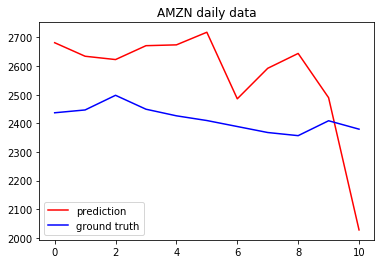

In [13]:
main_train_daily('AMZN', 4000, 4, 0.000001)